## INTRODUCTION : 

This notebook contains the main code used in the first part of the paper (GFP diffusion with one receptor, and no signaling). It is used to produce curves taking into account boosting of GFP fluorescence by Nb1^{high}.

## Part 1 : Simulations of gradient formation and figures : 

In [1]:
#import packages : 

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline
import pandas as pd
import numpy as np
import os
import sys 
import random
from scipy.optimize import minimize

##import experimental data  : 

dir='./Experimental_Data'

#import data from high affinity nanobody (VHH)  experiment
vhh=pd.read_csv(dir+'/hh-VHH-CD8.csv')
col = vhh.loc[: , "1":"11"]
vhh['signal_mean'] = col.mean(axis=1)
vhh['signal_std'] = col.std(axis=1)
vhh['signal_var'] = col.var(axis=1)


#import data from high affinity nanobody + fat body trap experiment

fat_body=pd.read_csv(dir+'/20190712 ptc-sGFP hh-VHH-CD8, lpp>VHH-CD8.csv')
col = fat_body.loc[: , "1":"7"]
fat_body['signal_mean'] = col.mean(axis=1)
fat_body['signal_std'] = col.std(axis=1)
fat_body['signal_var'] = col.var(axis=1)


#import data from high affinity nanobody overexpression  experiment

vhh_gal4=pd.read_csv(dir+'/20190709 ptc-sG hhG4 UAS-VHH-CD8_copy_pandas.csv')
col = vhh_gal4.loc[: , "sample1":"sample8"]
vhh_gal4['signal_mean'] = col.mean(axis=1)
vhh_gal4['signal_std'] = col.std(axis=1)
vhh_gal4['signal_var'] = col.var(axis=1)

#import data from low affinity nanobody experiment
lag3=pd.read_csv(dir+'/20190307 ptc-sG hh-LaG3-CD8.csv')
col = lag3.loc[: , "1":"10"]
lag3['signal_mean'] = col.mean(axis=1)
lag3['signal_std'] = col.std(axis=1)
lag3['signal_var'] = col.var(axis=1)



In [2]:
## Simulating gradient formation : 
#domain size (in um)
L = 116
#size of the source (in um)
source_size_value = 26
#number of points within the domain
nb_x_points = 400
#array of values of x positions
#one takes nb_x_points+1, assuming that nb_x_points is even, to make sure
#that the point 0 is included in the array.
#also round up by 12 decimals to make sure that 0 is at 0.
x_array = np.around(np.linspace(-(1.0 - 1.0 / 2.0/ float(nb_x_points)) * L,
                      (1.0 - 1.0 / 2.0/ float(nb_x_points)) * L,
                      nb_x_points+1),
                    12)
#define a set of masks which are useful to solve the equations.
mask_tissue_posterior = x_array >= 0
mask_tissue_anterior = x_array < - source_size_value
mask_source = (x_array >=-source_size_value) &(x_array <0)
#spatial resolution
delta_x = x_array[1]-x_array[0]
#define a function that will return the time evolution of the concentration profile
def dcdt_function(c_array,
                  t,
                  J,
                  D,
                  h,
                  k_on,
                  k_off,
                  jr,
                  kappa_H,
                  source_size,
                  k_H):
    """Differential equations for the concentration equation, discretized in x,
    and for the evolution of the source concentration.
    c_array is the current concentration profile,
    t is the time point
    J is the influx from the source
    D is the diffusion constant
    h is the size of the intercellular space
    k_on is the on rate to receptors
    k_off is the off rate from receptors
    jr is the product of k, the effective degradation rate,
    and nT, the total density of receptors
    kappa_H is the exchange rate between tissue and hemolymph
    source_size is the length of the source
    k_H is the degradation rate in the hemolymph
    """
    #cH is the concentration in the hemolymph
    #here always assumed to be at equilibrium
    cH = kappa_H * np.mean(c_array)/(kappa_H + k_H)
    #calculate second derivative, imposing boundary conditions on the first derivative
    #on the left the derivative is imposed to vanish
    #on the right the derivative is imposed to vanish
    cxx = np.zeros(len(c_array))
    cxx[1:-1] = (c_array[2:]+c_array[0:-2] - 2.0 * c_array[1:-1]) / (delta_x**2)
    cxx[0] = (c_array[1]-c_array[0]) / (delta_x**2)
    cxx[-1] = (c_array[-2]-c_array[-1]) / (delta_x**2)
    # Compute dc/dt, the change of concentration
    dcdt_vector = np.zeros(len(x_array))
    dcdt_vector[mask_source] = (D * cxx[mask_source]
                                + J
                                - kappa_H * (c_array[mask_source] - cH))
    dcdt_vector[mask_tissue_posterior] =  (D * cxx[mask_tissue_posterior]
                                          - 1.0 / h * k_on
                                           * jr *c_array[mask_tissue_posterior] 
                                          /(k_off + k_on * c_array[mask_tissue_posterior])
                                          - kappa_H *
                                           (c_array[mask_tissue_posterior] - cH))
    dcdt_vector[mask_tissue_anterior] =  (D * cxx[mask_tissue_anterior]
                                          - kappa_H *
                                          (c_array[mask_tissue_anterior] - cH))
    #return the vector dc/dt 
    return dcdt_vector

In [3]:
#Set parameters :  
#diffusion constant in um/s^2
D_value = 21 
#size of intercellular space in um
h_value = 0.02 
# on rate for the high affinity nanobody, in /nM/s
k_on_value = 7.7 * 10 **(-4) 
# off rate for the high affinity nanobody, in /s
k_off_value = 1.7 * 10 ** (-4) 
# on rate for the low affinity nanobody,in /nM/s
k_on_value_LAG3 = 2 * 10 ** (-3) 
# off rate for the low affinity nanobody, in /s
k_off_value_LAG3 = 5 * 10 ** (-2) 
# Length of the source, in microns
source_size_value = 26. 
#normalized receptor density
nT_value=1 

In [4]:
def calculate_approximate_analytical_solution(J,
                                              D,
                                              h,
                                              k_on,
                                              k_off,
                                              jr,
                                              kappa_H,
                                              source_size,
                                              k_H):

    k_r = jr/h * k_on/(k_off)
    ell = np.sqrt(D/(k_r+kappa_H))
    ell_0 = np.sqrt(D/kappa_H)
    cH = J/L *(source_size - (ell_0-ell)*(1-np.exp(-source_size/ell_0)))/(2*k_H + k_r * kappa_H/(kappa_H+k_r))
    c0 = ell/kappa_H/(ell+ell_0) *(cH * kappa_H * k_r/(kappa_H+ k_r) + J *(1- np.exp(-source_size / ell_0)))
    C_1 = c0 + J / 2.0 / kappa_H * (-2.0 + np.exp(-source_size / ell_0)) - cH * k_r/(k_r+kappa_H)
    C_2 = - J /2.0 / kappa_H * np.exp(-source_size /ell_0)
    C_3 =  ((-J * (k_r + kappa_H) + kappa_H * (-cH * k_r 
                                             + c0 * (k_r+kappa_H)) 
                                             + J * (k_r + kappa_H) * np.cosh(source_size/ell_0)
                                             )
            /(kappa_H * (k_r + kappa_H))
            )
    initial_condition = np.zeros(len(x_array))
    initial_condition[mask_tissue_posterior] = c0 * np.exp(-x_array[mask_tissue_posterior] / ell) + cH * kappa_H/(kappa_H+k_r)
    initial_condition[mask_tissue_anterior] = cH + C_3 * np.exp(x_array[mask_tissue_anterior] / ell_0)
    initial_condition[mask_source] = (cH + J/kappa_H+
                                             C_1 * np.exp(x_array[mask_source] / ell_0) + 
                                             C_2 * np.exp(-x_array[mask_source] / ell_0)
                                             )
    return(initial_condition)

In [5]:
def predicted_bound_GFP_function(x_data,
                                 c_data,
                                 J,
                                 D,
                                 h,
                                 k_on,
                                 k_off,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H,
                                 precision):
    #"precision" stops the simulation if a steady state has been reached,
    # defined as a small change occurring in 500s.
    time_0 = 500
    nb_time_points = 100
    pseudo_time_array = np.linspace(0, time_0, nb_time_points)
    #set-up an initial condition which is approximately correct to
    #accelerate the fit
    initial_condition = calculate_approximate_analytical_solution(J,
                                         D,
                                         h,
                                         k_on,
                                         k_off,
                                         jr,
                                         kappa_H,
                                         source_size,
                                         k_H)
    # calculate the profile of free GFP
    sol = odeint(dcdt_function,
                 initial_condition,
                 pseudo_time_array,
                 args=(J, D, h, k_on, k_off, jr, kappa_H, source_size, k_H)
                 )
    sol1=sol[-1, :]
    sol2=sol[-2, :]
    j=0
    while np.mean(np.square(sol1/sol2-1))>precision : 
        j+=1
        pseudo_time_array = np.linspace((j-1)*time_0, j*time_0, nb_time_points)
        sol = odeint(dcdt_function,
                     sol1,
                     pseudo_time_array,
                     args=(J, D, h, k_on, k_off, jr, kappa_H, source_size, k_H)
                     )
        sol1=sol[-1, :]
        sol2=sol[-2, :]
    final_sol_free_GFP = sol[-1, :]
    #posterior = where the receptors are expressed
    mask_tissue_posterior = x_array >= 0
    final_sol_bound_GFP=np.zeros_like(final_sol_free_GFP)
    # from the profile of free GFP, calculate the profile of bound GFP
    final_sol_bound_GFP[mask_tissue_posterior] = (k_on * 
                                                  nT_value * 
                                                  final_sol_free_GFP[mask_tissue_posterior]
                                                  /(k_off 
                                                    + k_on 
                                                    * final_sol_free_GFP[mask_tissue_posterior]))
    
    #The global variable nT is just a scaling factor.
    #By setting it to 1, this function returns the normalized 
    #profile of bound receptors nb/nT. 
    #For special cases where the total number of receptors varies we change nT.
    
    #Finally interpolate on the x experimental grid.
    predicted_bound_GFP = np.interp(x_data, x_array, final_sol_bound_GFP)
    return predicted_bound_GFP

## Part 1 : Fitting the parameters taking boosting in account

In [6]:
boost_factor=1.5 
# if GFP-Nb-high fluorescence 1.5 more than GFP-Nb-low,
#we need to increase the NB-low concentration by 1.5 to compensate
# We first define the function that we minimize during the fit  : 
def curve_fit_function_minimization_boosting(x_data_vhh,
                                             c_data_vhh,
                                             x_data_fat_body,
                                             c_data_fat_body,
                                             x_data_lag3,
                                             c_data_lag3,
                                             J, D, h,
                                             k_on,
                                             k_off,
                                             k_on_lag3,
                                             k_off_lag3,
                                             jr,
                                             kappa_H,
                                             source_size,
                                             k_H,
                                             k_H_fat_body):
    predicted_bound_GFP_vhh =\
    predicted_bound_GFP_function(x_data_vhh,
                                 c_data_vhh['signal_mean'][7:211],
                                 J, 
                                 D,
                                 h,
                                 k_on,
                                 k_off,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H,
                                 precision)
    predicted_bound_GFP_fat_body =\
    predicted_bound_GFP_function(x_data_fat_body,
                                 c_data_fat_body['signal_mean'][7:211],
                                 J, 
                                 D,
                                 h,
                                 k_on,
                                 k_off,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H_fat_body,
                                 precision)
    predicted_bound_GFP_lag3 =\
    predicted_bound_GFP_function(x_data_lag3,
                                 c_data_lag3['signal_mean'][7:211],
                                 J, 
                                 D,
                                 h,
                                 k_on_lag3,
                                 k_off_lag3,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H,
                                 precision)
    #calculate the mean of the vhh experiment 
    #this is used to compare different curves
    sim_mean = np.mean(predicted_bound_GFP_vhh)
    exp_mean = np.mean(vhh['signal_mean'][7:211])
    #calculate differences for each individual experimental curves (10 vor vhh, 6 for the fat body trap, and 9 for lag3)
    diff_vhh=[];diff_lag3=[];diff_fat_body=[];
    for i in range(11):
        if i!=4 : 
            diff_vhh.append(predicted_bound_GFP_vhh / sim_mean - c_data_vhh[str(i+1)][7:211]/exp_mean)
        else : #special case as this one curve has data on a shorter total length
            diff_vhh.append(predicted_bound_GFP_vhh[:183] / sim_mean - c_data_vhh[str(i+1)][7:190]/exp_mean)
    
    for i in range (7) :
        diff_fat_body.append( (predicted_bound_GFP_fat_body / sim_mean - c_data_fat_body[str(i+1)][7:211] / exp_mean))
    
    for i in range (10) :
        diff_lag3.append(predicted_bound_GFP_lag3/ sim_mean - c_data_lag3[str(i+1)][7:211]*boost_factor/ exp_mean)
        
    #sum the squares of differences
    diff_vhh=[item for sublist in diff_vhh for item in sublist]
    diff_lag3=[item for sublist in diff_lag3 for item in sublist]
    diff_fat_body=[item for sublist in diff_fat_body for item in sublist]
    diff_tot=np.concatenate((diff_vhh,diff_lag3,diff_fat_body))
    print('Energy',np.sum(np.square(diff_tot)))
    print(J, kappa_H, k_H, k_H_fat_body, jr)
    return np.sum(np.square(diff_tot)) 

In [7]:
#initial conditions for the minimization process: format [J,kappa,kh,kh,jr]
precision =1e-12
IC=np.array([0.30434832, 0.07535886, 0.00998797, 0.19439367, 0.00262643]) 
#warning : that minimization step can be rather long (1 hour)
res = minimize(lambda x: curve_fit_function_minimization_boosting(vhh['distance'][7:211]-vhh['distance'][7],vhh
                                                          ,fat_body['distance'][7:211]-fat_body['distance'][7],
                                                          fat_body,
                                                          lag3['distance'][7:211]-lag3['distance'][7],
                                                          lag3,
                                                          x[0],
                                                          D_value,
                                                          h_value,
                                                          k_on_value,
                                                          k_off_value,
                                                          k_on_value_LAG3,
                                                          k_off_value_LAG3,
                                                          x[4],
                                                          x[1],
                                                          source_size_value,
                                                          x[2],
                                                          x[3]),
                                                          IC,
                                                          method = 'Nelder-Mead',
                                                          tol=1.0e-5)

    
result=np.concatenate((IC,res.x,[res.fun]))
print(res.x)


Energy 66.60502198912272
0.30434832 0.07535886 0.00998797 0.19439367 0.00262643
Energy 68.0736846939966
0.31956573600000004 0.07535886 0.00998797 0.19439367 0.00262643
Energy 67.60106914973568
0.30434832 0.07912680300000001 0.00998797 0.19439367 0.00262643
Energy 69.29193128967826
0.30434832 0.07535886 0.010487368500000002 0.19439367 0.00262643
Energy 66.64055029919645
0.30434832 0.07535886 0.00998797 0.2041133535 0.00262643
Energy 66.14242785401007
0.30434832 0.07535886 0.00998797 0.19439367 0.0027577515
Energy 63.14531367830645
0.31043528639999995 0.07686603719999999 0.0094885715 0.19828154339999995 0.0026789585999999997
Energy 60.5694581565736
0.3134787695999999 0.07761962579999998 0.008989173 0.2002254800999999 0.0027052229
Energy 65.90083546354094
0.29278308383999985 0.07777034352000001 0.009588451199999999 0.20061426743999997 0.002710475759999999
Energy 62.88162709338313
0.3033744053759998 0.07345981672799999 0.009428643679999996 0.20310250641599994 0.0027440940639999988
Energy 6

Energy 42.91048924883
0.37507437198252214 0.06888384111848168 0.005884534609747125 0.18008198037843798 0.0033278068845204014
Energy 42.60508076557505
0.35386302476345854 0.07215205235544175 0.005830522813259208 0.19706814874016254 0.0031969695072581097
Energy 42.33851302109852
0.3687080163612271 0.07231781342975105 0.006093549676416638 0.18237260584119708 0.003291113868409244
Energy 42.29859967179876
0.37638197410715635 0.07323803988319713 0.006306141321863981 0.173820752013923 0.003340657278619194
Energy 42.235407850176166
0.3625147600993327 0.07241686406663161 0.005864787811461738 0.18153230778343787 0.003283611551865218
Energy 42.224171541043006
0.3615913734439544 0.07302760830021271 0.005790187153184589 0.17592527868977337 0.0033054915149474534
Energy 42.20504720262154
0.36747720683413243 0.07449603685128986 0.006159346826566886 0.17342321122069815 0.003293628276456563
Energy 42.4601244744144
0.3712030830894588 0.07662718165732899 0.006369197034784356 0.16326854039911298 0.00331471

Energy 42.013047257317666
0.3706545952259426 0.07453048136237211 0.0060127407416368656 0.16288438353067952 0.0033522565381135104
Energy 42.01384486666282
0.371354752145174 0.07469299076297782 0.006017279887882783 0.16211245151441958 0.0033561369867773656
Energy 42.01300715345931
0.37051775652767843 0.07446231454366867 0.005999261740419231 0.16341404575171165 0.0033509632406055487
Energy 42.01494773761327
0.37100360625607953 0.07447064015356 0.006034708830744745 0.16373253619168884 0.0033513082424131493
Energy 42.01280847081542
0.37067786932581226 0.07454232016202439 0.005995569052991782 0.16285819339839958 0.0033527124351504546
Energy 42.012328099071034
0.37070428072739814 0.07446349886637149 0.006007215966287475 0.16334511668008506 0.0033507387282224414
Energy 42.01213137263889
0.3706493626596461 0.07441300442449386 0.006007880040123554 0.16355430263741327 0.003349381311031123
Energy 42.01295931261987
0.3698148224833323 0.07445305159783218 0.005989222206876229 0.1636794951091527 0.003

Energy 41.939021345310906
0.30987910094982507 0.07029346931427627 0.005040408696990101 0.14874342485576603 0.002901297394957557
Energy 41.92085548113225
0.32473400498101557 0.07095888825804181 0.00530168965755355 0.1537423225118449 0.0030133849259998896
Energy 41.92325206006298
0.31569212563976734 0.07049254766620017 0.005182984163444789 0.15654443016955327 0.002939071782247061
Energy 41.921282851619466
0.314865592396681 0.07055750465570876 0.005198999166041432 0.15280167242141263 0.0029414912392636636
Energy 41.933294135839375
0.3139661007932668 0.07041703452730999 0.0050956545044912975 0.15191794838623407 0.0029386593332225985
Energy 41.91856954964461
0.3246837765998339 0.07119975434493701 0.005347115714388498 0.15587056141672603 0.0030077045043214283
Energy 41.93446032763234
0.330126970739549 0.07166803048341724 0.005409259079111562 0.15229206980910653 0.0030577602011596554
Energy 41.916587855012146
0.3193008369147128 0.07078641837050444 0.005239552892361482 0.1554813400794416 0.002

Energy 41.91509901787495
0.31961515104462934 0.07074899861381351 0.005242709963682592 0.15427451905338624 0.0029715928485802194
Energy 41.91509160583507
0.3192222468663257 0.07072797507331763 0.005238179420267053 0.15410894111996912 0.00296866115558333
Energy 41.91509807457915
0.3190739540432531 0.07070640088048838 0.005234660826434381 0.15405701399681626 0.0029676458050403474
Energy 41.915091358437934
0.3194049391651692 0.07074164753573164 0.00524080278401051 0.15418291241709034 0.002969998288951643
Energy 41.91509363412967
0.3192682733005745 0.07072084226142897 0.0052393882079643204 0.15418873927918414 0.002968915454871307
Energy 41.91509059634887
0.3193257775829405 0.07073500380865982 0.005239013392317946 0.1541362838778228 0.0029694674972919905
Energy 41.915094487628686
0.3193990505512162 0.07073816123356813 0.005241079765711196 0.1540989365091452 0.0029699208569017206
Energy 41.91509020924232
0.3192843052054453 0.07072904399181786 0.005238556862650722 0.15416568862650257 0.0029691

In [7]:
#Plot of the experimental data with boosting parameters : 
#influx from the source in nM/s
J_value_boost = 0.32 
#exchange rate between tissue and hemolymph, in /s
kappa_H_value_boost = 0.07 
#effective degradation rate in the haemolymph
k_H_value_boost = 0.0052
#effective degradation rate in the haemolymph in the fat body trap experiment
k_H_fat_body_value_boost=0.15
#product of degradation rate and receptor density in nM.um/s
jr_value_boost = 3.0e-3
precision=1e-12
nT_value = 1
#simulate the vhh experiment 
result_vhh = predicted_bound_GFP_function(vhh['distance'][7:]-vhh['distance'][7],
                                          vhh['signal_mean'][7:],
                                          J_value_boost,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          k_off_value,
                                          jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_value_boost,precision) 
#simulate fat body experiment 
result_fat_body = predicted_bound_GFP_function(fat_body['distance'][7:299]-fat_body['distance'][7],
                                               fat_body['signal_mean'][7:299],
                                          J_value_boost,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          k_off_value,
                                          jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_fat_body_value_boost,precision)

#simulate experiment where the nanobody is now lag3
result_lag3 = predicted_bound_GFP_function(lag3['distance'][7:295]-lag3['distance'][7],
                                           lag3['signal_mean'][7:295],
                                           J_value_boost,
                                           D_value,
                                           h_value,
                                           k_on_value_LAG3,
                                           k_off_value_LAG3,
                                           jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_value_boost,precision)
#simulating an increase of receptors 
nT_value = 20*nT_value #In "the wall" the production and consequently the number of receptors is increased by approx. 20 fold:
result_wall=predicted_bound_GFP_function(vhh_gal4['distance'][7:295]-vhh_gal4['distance'][7],
                                          vhh_gal4['signal_mean'][7:295],
                                          J_value_boost,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          k_off_value,
                                          20*jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_value_boost,precision)


### Figure S4-B : 

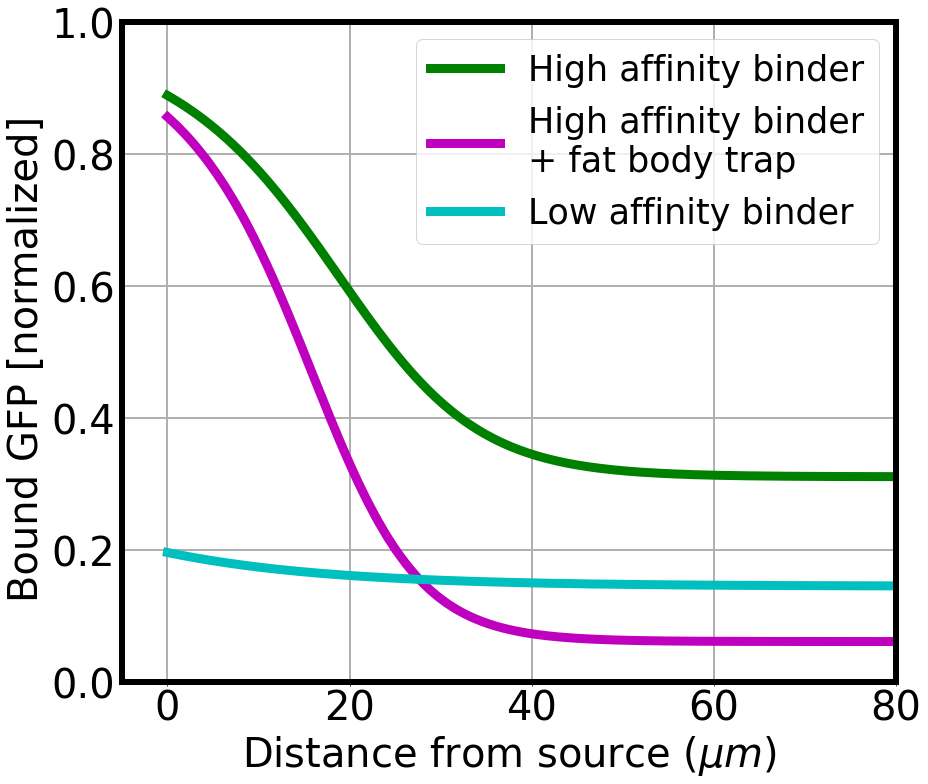

In [8]:
f=plt.figure(figsize = (13,11))
ax1 = plt.subplot(111)
ax1.plot(vhh['distance'][7:]-vhh['distance'][7],
         result_vhh,
         label = "Bound GFP",
         lw=9,
         ms = 10,
         color = "g")
ax1.plot(fat_body['distance'][7:299]-fat_body['distance'][7],
         result_fat_body,
         label = "Bound GFP",
         lw=9,
         ms = 10,
         color = "m")
ax1.plot(lag3['distance'][7:295]-lag3['distance'][7],
         result_lag3,
         label = "Bound GFP",
         lw=9,
         ms = 10,
         color = "c")
y1min= 0
y1max=1
ax1.set_xlim(-5,80)
ax1.set_ylim(y1min,y1max)
plt.tick_params(labelsize=40)

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(6)

plt.ylabel(r"Bound GFP [normalized] ",fontsize =40)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =40)
plt.legend(['High affinity binder',
            'High affinity binder\n+ fat body trap',
            'Low affinity binder' ],
           fontsize=35)
plt.grid(lw=2)
plt.tight_layout()
plt.savefig('./Figures/Fig-S4-B.eps',format='eps',dpi=600)


## Figure S4-D :  Effect of increasing the number of receptors :


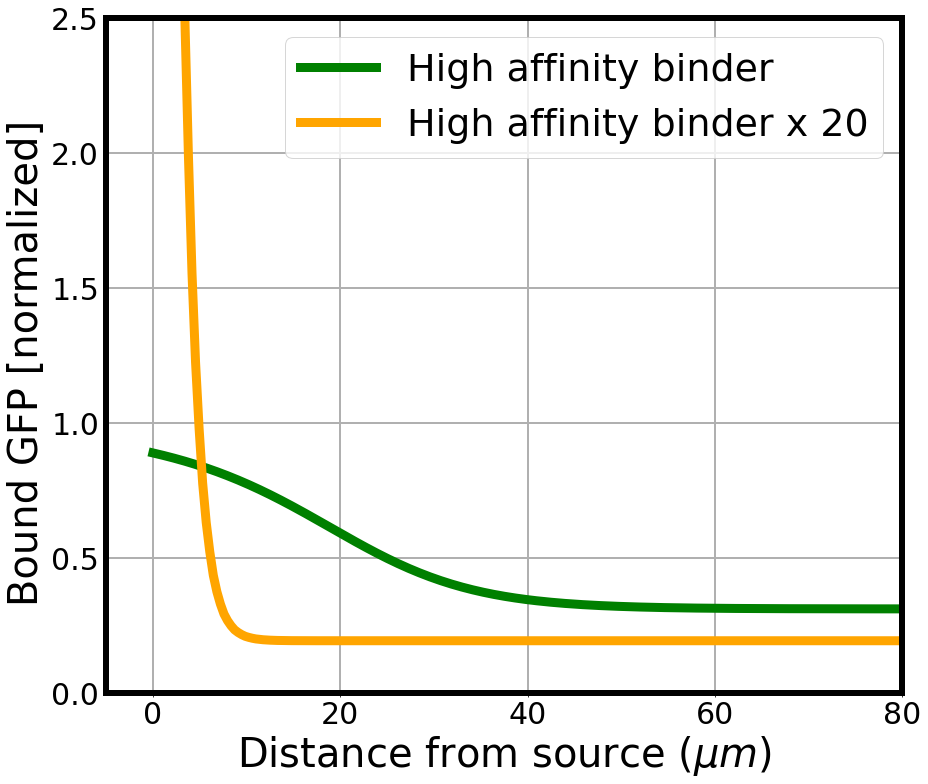

In [9]:
f2=plt.figure(figsize = (13,11))
ax2 = plt.subplot(111)
ax2.plot(vhh['distance'][7:]-vhh['distance'][7],
         result_vhh,
         lw=9,
         ms = 10,
         color = "g")
ax2.plot(vhh_gal4['distance'][7:295]-vhh_gal4['distance'][7],
         result_wall,
         lw=9,
         ms = 10,
         color='orange')
y2min= 0
y2max=2.5
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
ax2.set_xlim(-5,80)
ax2.set_ylim(y2min,y2max)
plt.ylabel(r"Bound GFP [normalized] ",fontsize =40)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =40)
plt.tick_params(labelsize=30)
plt.legend([r'High affinity binder',
            r'High affinity binder x 20'],
           fontsize=38)
plt.grid(lw=2)
plt.tight_layout()
plt.savefig('./Figures/Fig-S4-D.eps',format='eps',dpi=600)


## Figure S4-F Effect of changing strength of the source : 


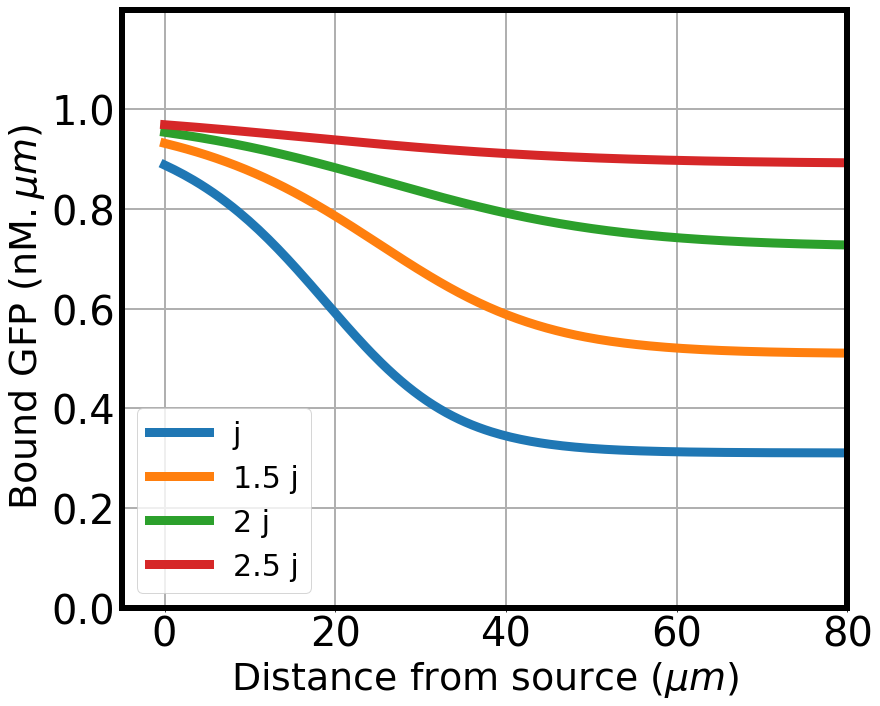

In [10]:
nT_value = 1
plt.figure(figsize = (13,11))
leg=[]
for jp in [J_value_boost,1.5*J_value_boost,2*J_value_boost,2.5*J_value_boost] : 
    result = predicted_bound_GFP_function(vhh['distance'][7:]-vhh['distance'][7],
                                          vhh['signal_mean'][7:],
                                          jp,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          k_off_value,
                                          jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_value_boost,precision)
    plt.plot(vhh['distance'][7:]-vhh['distance'][7],result, label = "Bound GFP",  lw=9,ms = 10)
    leg.append("j="+str(jp))
plt.ylabel(r"Bound GFP (nM$.\mu m$)  ",fontsize =38)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =38)
plt.tick_params(labelsize=30)
plt.grid(lw=2)  
plt.legend(['j',r'1.5 j',r'2 j',r'2.5 j'],prop={'size': 30})
plt.ylim(0,1.2)
plt.xlim(-5,80)
plt.yticks([0, 0.2,0.4,0.6,0.8,1.0])
plt.tick_params(labelsize=40)
ax2=plt.gca()
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
plt.savefig('./Figures/Fig-S4-F.eps',format='eps',dpi=600)